<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [4]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'motorbike' in obj['label'].lower():
                obj['label'] = 'bike'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bicycle'
            else:
                print obj

In [5]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [6]:
add_proper_labels(annotations)

In [7]:
annotations = np.asarray(annotations)

In [8]:
counts = get_label_counts(annotations)

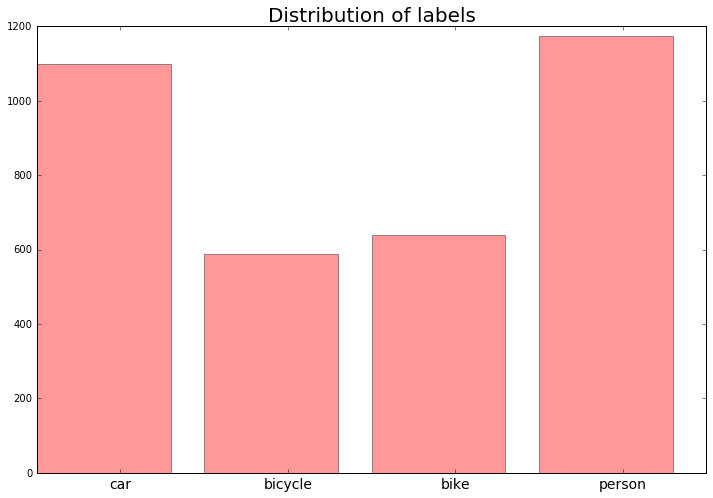

In [9]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [10]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [11]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [12]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [13]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, int(im.shape[1] * self.xi))
        yi = max(0, int(im.shape[0] * self.yi))
        xf = min(im.shape[1], int(im.shape[1] * self.xf))
        yf = min(im.shape[0], int(im.shape[0] * self.yf))
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [14]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            objs = annotations[i+j]
            im = imread(objs[0]['image'])
            old_size = im.shape
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [15]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j]
                im = imread(objs[0]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = 1.
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .3 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [16]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [17]:
S = (6,6)
B = 2
C = 4

In [18]:
num_epochs = 1000
batch_size = 50

In [ ]:
# Xtest,ytest = [t for t in generate_data_2(train_annotations[:1], C, batch_size=batch_size)][0]
Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)

In [35]:
input_shape = (224,224)
net = {}
net['input'] = InputLayer((None,3) + input_shape)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3))
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3))
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1))


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.5), 2048)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [36]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [37]:
net['output'] = net['dense2']
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [30]:
load_weights = False
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [38]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [39]:
yl = yolo.YoloObjectDetector(net, (None, 3) + input_shape, C, S, B) 

cost = yl._get_cost_optim_multi(yl.output, ytest, S, B, C)

In [ ]:
train_loss, test_loss = yl.train(
    generate_data_3(train_annotations, C, size=input_shape, batch_size=batch_size, augment=1),
    generate_data_2(test_annotations, C, size=input_shape, batch_size=batch_size),
    lr=1e-5,
    epochs=num_epochs
)

Getting cost...
> /usr/local/python/bnr_ml/objectdetect/yolo.py(256)_get_cost()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/yolo.py(256)_get_cost()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]


In [ ]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [ ]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

In [ ]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx][100:], 'b')
plt.plot(test_loss_total[idx][100:], 'r')

In [1011]:
gen = generate_data_2(train_annotations[200:300], C, max_objs=5)

In [1012]:
testdat = [t for t in gen]

In [1013]:
Xtest, ytest = testdat[0]

In [864]:
out_fn = theano.function([yl.input], yl.output_test)

In [1014]:
Xtest_out = out_fn(Xtest)

In [1034]:
N = int(np.random.rand() * Xtest.shape[0])

In [1035]:
coords = yolo.YoloObjectDetector.nms(Xtest_out[N], S, B, C, thresh=.3, overlap=.3)

In [1036]:
im = yolo.YoloObjectDetector.draw_coord(swap(Xtest[N]), coords, get_label_from_num)

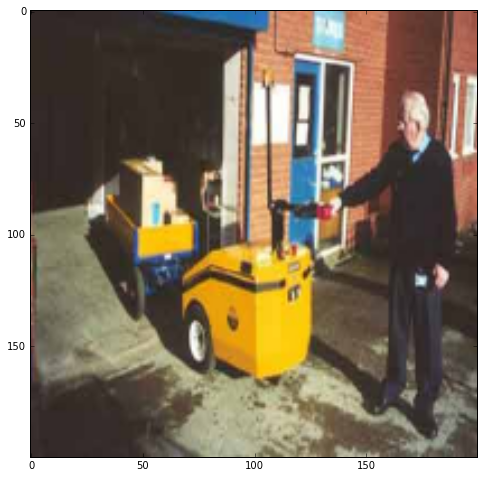

In [1037]:
plt.figure(figsize=(8,8))
plt.imshow(im)

In [663]:
pred = np.copy(Xtest_out[N])
score = pred[[4,9]] * pred[-C:].max(keepdims=True)
score = score.flatten()
args = score.argsort()[::-1][:10]
preds = []
for i in range(args.size):
    idx = np.unravel_index(args[i], pred[[4,9]].shape)
    crd = pred[5*idx[0]:5*idx[0] + 4,idx[1], idx[2]]
    tmp = crd[[2,3]]
    tmp[tmp<1] = 0.5*tmp[tmp<1]**2
    tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
    crd[[2,3]] = tmp
    crd = crd.tolist()
    crd[0], crd[1] = crd[0] + np.float_(idx[2]) /S[1], crd[1] + np.float_(idx[1]) / S[0]
    crd.append(score[args[i]])
    preds.append(crd)
preds = np.asarray(preds)

In [660]:
nms(preds, .3)

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 8


array([[ 0.10364119,  0.11493982,  0.55785549,  0.52974772,  0.52931499]])

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 8
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


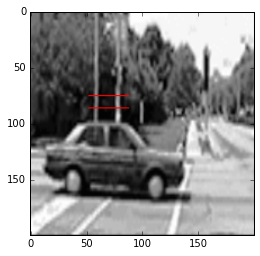

In [664]:
plt.imshow(draw_coord(swap(Xtest[N]), nms(preds, .3)[0], None))

In [ ]:
tmp = np.arange()

In [508]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [549]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a, b = draw_best(swap(Xtest[N]), Xtest_out[N], num = 5, thresh=.2)

12


['car', 'car', 'car', 'car', 'car']


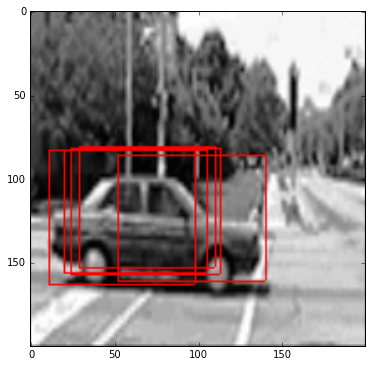

In [550]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print b
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [443]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)